<a href="https://colab.research.google.com/github/smkim0508/COS484-Notes/blob/main/A1P1_Smoothing_(COS484_S2026).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Programming Question 1
Welcome to the programming portion of the assignment! Each assignment throughout the semester will have a theory portion and a programming portion. We will be using [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), so if you have never used it before, take a quick look through this introduction: [Working with Google Colab](https://docs.google.com/document/d/1LlnXoOblXwW3YX-0yG_5seTXJsb3kRdMMRYqs8Qqum4/edit?usp=sharing).

We'll also be programming in Python, which we will assume a basic familiarity with. Python has fantastic community support and we'll be using numerous packages for machine learning (ML) and natural language processing (NLP) tasks.

### Learning Objectives
In this problem we will experiment with language models and implement smoothing. We will also see effects of using unigram/bigram LMs and the size of the training data.

### Data preprocessing

In this section, you should write methods to load data and clean (tokenize) it. You will need to write two functions for tokenization. One function, **basicTokenize**, should simply split the text using whitespace. The other function, **nltkTokenize**, should implement NLTK tokenization. Write another function to count the top k most frequent words in a list. You may structure this code however you like, but we suggest constructing a Tokenizer class to encompass these functions.

In [2]:
import nltk
nltk.download('punkt_tab')

class Tokenizer():

  def __init__(self):
    pass

  def basicTokenize(self, text: str) -> list[str]:
    """
    splits text by whitespace
    """
    return text.split()

  def nltkTokenize(self, text: str) -> list[str]:
    """
    splits token using nltk library
    """
    return nltk.word_tokenize(text)

  def count_top_words(self, words: list[str], k: int) -> list[tuple[str, int]]:
    """
    counts the top k words and returns the top k as a sorted list
    """
    word_counts = {}
    for word in words:
      if word in word_counts:
        word_counts[word] += 1
      else:
        word_counts[word] = 1

    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_word_counts[:k]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
tokenizer = Tokenizer()
# test tokenization
text = "This is a test string. I like food."
basic_tokens = tokenizer.basicTokenize(text)
nltk_tokens = tokenizer.nltkTokenize(text)

print(f"Basic Tokenization: {basic_tokens}")
print(f"NLTK Tokenization: {nltk_tokens}")

Basic Tokenization: ['This', 'is', 'a', 'test', 'string.', 'I', 'like', 'food.']
NLTK Tokenization: ['This', 'is', 'a', 'test', 'string', '.', 'I', 'like', 'food', '.']


In [4]:
top_words = tokenizer.count_top_words(nltk_tokens, 3)
top_words

[('.', 2), ('This', 1), ('is', 1)]

### Language Modeling and Smoothing
In this section, you should write methods to train and test a bigram language model. These functions will need to include computing bigram counts, estimating bigram probabilities, and calculating perplexity on the test set. You should also implement a method that can later be called to modify the probabilities with add-alpha smoothing. We suggest encompassing these functions in a LanguageModel class to make experiments easier to run.

In [5]:
import math
from tqdm import tqdm

class LanguageModel():

  def __init__(self, word_to_index: dict, index_to_word: list):
    self.word_to_index = word_to_index
    self.index_to_word = index_to_word
    self.vocab_size = len(word_to_index)
    # init VxV matrix for cooccurrence (bigram count), initialized to zeros
    self.bigram_counts = [[0] * self.vocab_size for _ in range(self.vocab_size)]
    # init VxV matrix for bigram probabilities
    self.bigram_probs = [[0.0] * self.vocab_size for _ in range(self.vocab_size)]

  def compute_bigram_counts(self, tokens: list[str]):
    """
    Computes bigram counts from a list of tokens.
    """
    for i in tqdm(range(len(tokens) - 1), desc="bigram counts"):
      word1 = tokens[i]
      word2 = tokens[i+1]

      if word1 in self.word_to_index and word2 in self.word_to_index:
        idx1 = self.word_to_index[word1]
        idx2 = self.word_to_index[word2]
        self.bigram_counts[idx1][idx2] += 1

  def compute_bigram_probs(self, alpha = 0.0):
    """
    Compute a bigram probability matrix using bigram counts.
    """

    for i in tqdm(range(self.vocab_size), desc="bigram probability"):
      row_sum = sum(self.bigram_counts[i])
      for j in range(self.vocab_size):
        # prob for an element is the count / total number of counts in this row
        # NOTE: adds alpha to smooth
        d = (row_sum + (alpha * self.vocab_size))
        if d == 0:
          print(f"row sum is 0, please adjust alpha value to prevent division by 0")
          break # skips the rest of this row, leaves the prob as 0.0
        self.bigram_probs[i][j] = (self.bigram_counts[i][j] + alpha) / d

  def perplexity(self, tokens: list[str]) -> float:
    """
    Computes perplexity of a tokenized sentence.
    tokens should include <s> and </s>
    Uses the pre-computed bigram probabilities.
    """

    log_sum = 0.0
    N = 0

    for i in tqdm(range(len(tokens) - 1), desc="perplexity"):
      prev_word = tokens[i]
      curr_word = tokens[i+1]

      i1 = self.word_to_index[prev_word]
      i2 = self.word_to_index[curr_word]

      prob = self.bigram_probs[i1][i2]

      # if any prob = 0, log -> -inf, so perplexity -> +inf
      if not prob:
        return float('inf')

      log_sum += math.log(prob)
      N += 1

    return math.exp(-log_sum / N)

### Instantiate an LM and calculate perplexity
Write a wrapper method to train and evaluate a language model on a given train and dev corpus.

In [6]:
# training in this case -> calculating counts and probabilities; testing -> checking perplexity on test sentence.
def train_lm(language_model: LanguageModel, train_tokens: list[str]):
  """
  Takes an instance of LM model class and trains it.
  Uses training tokens given from train corpus.
  """
  language_model.compute_bigram_counts(train_tokens)
  language_model.compute_bigram_probs(alpha = 1.0)
  return language_model

def evaluate_lm(language_model: LanguageModel, test_tokens: list[str]) -> float:
  """
  Takes an instance of LM model class and evaluates it using perplexity.
  Uses test tokens given from training/validation corpus.
  """
  return language_model.perplexity(test_tokens)

### Load and tokenize the training and validation data using your code from the Data Processing section

You can download training and validation datasets for this problem from the links below:
*   Training data: https://princeton-nlp.github.io/cos484/assignments/a1/brown-train.txt
*   Validation data: https://princeton-nlp.github.io/cos484/assignments/a1/brown-val.txt


In [7]:
import os

# download data into data/... dir
if not os.path.exists('data'):
    os.makedirs('data')

# training
!wget -P data/ https://princeton-nlp.github.io/cos484/assignments/a1/brown-train.txt
# validation
!wget -P data/ https://princeton-nlp.github.io/cos484/assignments/a1/brown-val.txt

# training path, load data into train_text
file_path = 'data/brown-train.txt'

with open(file_path, 'r') as file:
    train_text = file.read()

# tokenize w/ nltk tokenizer
tokenizer = Tokenizer()
train_tokens = tokenizer.nltkTokenize(train_text)
# define vocab as unique set of words in training corpus
# NOTE: should it be unique set of words in training AND validation corpus?
vocabulary = sorted(list(set(train_tokens)))
vocab_size = len(vocabulary)

# map word to index for initializing LM
word_to_index = {word: i for i, word in enumerate(vocabulary)}

--2026-02-15 17:32:05--  https://princeton-nlp.github.io/cos484/assignments/a1/brown-train.txt
Resolving princeton-nlp.github.io (princeton-nlp.github.io)... 185.199.111.153, 185.199.108.153, 185.199.109.153, ...
Connecting to princeton-nlp.github.io (princeton-nlp.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3524251 (3.4M) [text/plain]
Saving to: ‘data/brown-train.txt.6’

brown-train.txt.6   100%[===================>]   3.36M  --.-KB/s    in 0.08s   

2026-02-15 17:32:05 (44.3 MB/s) - ‘data/brown-train.txt.6’ saved [3524251/3524251]

--2026-02-15 17:32:05--  https://princeton-nlp.github.io/cos484/assignments/a1/brown-val.txt
Resolving princeton-nlp.github.io (princeton-nlp.github.io)... 185.199.111.153, 185.199.108.153, 185.199.109.153, ...
Connecting to princeton-nlp.github.io (princeton-nlp.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888444 (868K) [text/plain]
Saving to: 

## Experiments

#### Plot the frequency of words
Code for sub-part (a)(b)

top 10 words in basic tokenization: [('UNK', 61019), ('the', 40854), ('of', 25087), ('and', 17563), ('to', 16190), ('a', 13659), ('in', 12973), ('is', 7378), ('that', 6324), ('for', 6000)]
top 10 words in nltk tokenization: [('UNK', 61019), ('the', 41029), ('of', 25132), (',', 23570), ('.', 17873), ('and', 17814), ('to', 16269), ('a', 13777), ('in', 13071), ('is', 7608)]


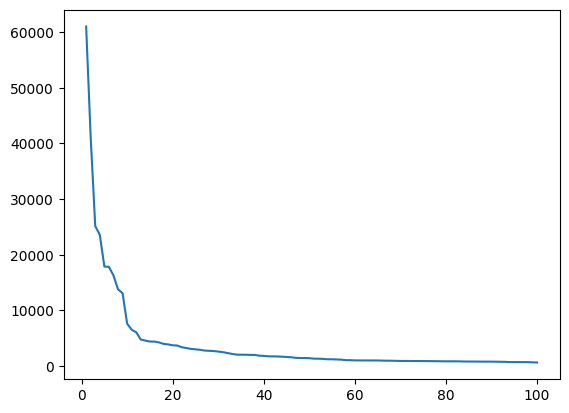

In [8]:
# a) tokenize and count top words from training corpus
nltk_train_tokens = tokenizer.nltkTokenize(train_text)
basic_train_tokens = tokenizer.basicTokenize(train_text)

top_ten_nltk = tokenizer.count_top_words(nltk_train_tokens, 10)
top_ten_basic = tokenizer.count_top_words(basic_train_tokens, 10)

print(f"top 10 words in basic tokenization: {top_ten_basic}")
print(f"top 10 words in nltk tokenization: {top_ten_nltk}")

# b) count top 100 words from nltk tokenization, then plot
import matplotlib.pyplot as plt

top_hundred_nltk = tokenizer.count_top_words(nltk_train_tokens, 100)

# parse x, y values to plot
ranks = [i for i in range(1, 101)]
frequencies = [freq for word, freq in top_hundred_nltk]

plt.plot(ranks, frequencies)
plt.show()

**(a) **Report the top 10 words ordered by their frequency in the training corpus, both using basicTokenize and nltkTokenize. What differences do you notice between the two?**

top 10 words in basic tokenization: [('UNK', 61019), ('the', 40854), ('of', 25087), ('and', 17563), ('to', 16190), ('a', 13659), ('in', 12973), ('is', 7378), ('that', 6324), ('for', 6000)]
top 10 words in nltk tokenization: [('UNK', 61019), ('the', 41029), ('of', 25132), (',', 23570), ('.', 17873), ('and', 17814), ('to', 16269), ('a', 13777), ('in', 13071), ('is', 7608)]

While the two tokenization method's resulting top 10 word frequencies look similar at first, below are some differences I noticed:
- articles, prepositions, conjunctions like 'the', 'a', 'of', 'to', 'and', etc. appear more frequently in NLTK version.
- punctuation marks like ',' or '.' appear far more frequently in the NLTK tokenization, this is likely because basic word tokenization using word split counts punctuation marks as part of the appended word, so their count is not found in isolation (very sparsely distributed among the appended words).

**(b) Using the nltkTokenize function you wrote, make a plot of the frequencies of words in the training corpus, ordered by their rank, i.e. most frequent word first, the second most word next, and so on on the x axis. Plot only the top 100 most common words to see the trend more clearly. What pattern do you observe in your plot regarding frequency and rank? Do the frequencies follow Zipf's law?**

There seems to be a small set of words whose frequency is extremely high relative to other words in the corpus, as shown by the extreme high starting point leading to a very sharp drop. Moreover, the rest of the words (majority) in the corpus display very low frequency relative to this small set of extremely high-frequency words, shown by the slow slope after the initial drop. This roughly follows Zipf's law, showing a graph similar to freq ~ C/rank, with some bumps in the curve (normal for real datasets).

#### Report the train and test perplexity after learning the language model
Code for sub-part (c)

In [ ]:
# init lm with word to index and index to word utils, then call helper train / test methods

# init
lm = LanguageModel(word_to_index, vocabulary)
# train
lm = train_lm(lm, train_tokens)

# load in val text and create validation tokens
file_path = 'data/brown-val.txt'
with open(file_path, 'r'):
  val_text = file.read()
valid_tokens = tokenizer.nltkTokenize(val_text)

# test
train_pp = evaluate_lm(lm, train_tokens)
valid_pp = evaluate_lm(lm, valid_tokens)

print("Train perplexity:", train_pp)
print("Valid perplexity:", valid_pp)


bigram probability:  96%|█████████▌| 15325/15956 [01:06<00:02, 243.12it/s]

**(c) Train the model and report its perplexity on the train and validation sets. Is the train or val perplexity higher and why?**

TODO: ANSWER THE QUESTION HERE (DOUBLE-CLICK TO EDIT)

**(c) What do you notice about the val perplexity and why is this the case?**

TODO: ANSWER THE QUESTION HERE (DOUBLE-CLICK TO EDIT)

#### Add-alpha smoothing
Code for sub-part (d)

**(d) Implement Laplace (add-$\alpha$) smoothing and retrain the model. Plot the perplexity on train and validation sets as a function of alpha (with values $10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10$).
What happens to the validation and training perplexity as we increase alpha and why does this happen?**

TODO: ANSWER THE QUESTION HERE (DOUBLE-CLICK TO EDIT)

**(d) What seems to be a good setting for alpha? Provide brief justification.**

TODO: ANSWER THE QUESTION HERE (DOUBLE-CLICK TO EDIT)

**(e) Based on your performance in the previous experiments, propose one idea apart from Laplace smoothing to
improve the performance of your bigram language model on the validation set. Briefly describe the modification,
explain why you expect it will improve validation perplexity, and discuss any potential limitations.**

TODO: ANSWER THE QUESTION HERE (DOUBLE-CLICK TO EDIT)

# LLM Prompts

If you used an AI tool to complete any part of this assignment, please paste all prompts you used to produce your final code/responses in the box below and answer the following reflection question.

Prompts Used:
*   
*   



**Reflection: What parts of the AI generated output required modification or improvement? Describe the feedback you gave the tool to produce your final output or any changes you had to make on your own.**

TODO: ANSWER THE QUESTION HERE (DOUBLE-CLICK TO EDIT)